# Connecting mocks to spectra.

This notebook presents QA checks of the code which assigns spectra to the mock catalogs.

## Initialize

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import warnings
import yaml
from glob import glob

In [3]:
# Note that you need the standard desi/conda dependencies + matplotlib, 
# basemap, and healpy to run this notebook.
import matplotlib.pyplot as plt
import fitsio
from astropy.table import Table, Column, vstack

In [42]:
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desiutil.plots import init_sky, plot_sky_binned
from desiutil.log import get_logger
log = get_logger()

## Section 1: Assess the input mock catalogs.

### 1a) Read the mocks.

In [5]:
def _GRFpath(sky=False):
    if sky:
        return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.1', '2048')
    else:
        return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'GaussianRandomField', 'v0.0.5')

In [6]:
def _BGSpath():
    return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'bgs', 'MXXL', 'desi_footprint', 'v0.0.3', 'BGS.hdf5')

In [7]:
def _lyapath():
    return os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'lya_forest', 'v0.0.2')

In [8]:
def _mwspath(main=True, WD=False, nearby=False):
    rootpath = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'mws')
    if main:
        return os.path.join(rootpath, 'galaxia', 'alpha', 'v0.0.3', 'bricks')
    if WD:
        return os.path.join(rootpath, 'wd', 'v0.0.2', 'mock_wd.fits')
    if nearby:
        return os.path.join(rootpath, '100pc', 'v0.0.3', 'mock_100pc.fits')

In [9]:
def read_GRF(fitsfile):
    """Read the Gaussian Random Field mocks."""
    import fitsio
    from astropy.table import Table, Column
    log.info('Reading {}'.format(fitsfile))
    dat = Table(fitsio.read(fitsfile, ext=1, upper=True))
    if 'random' not in fitsfile:
        dat.add_column(Column(name='Z', data=(dat['Z_COSMO'] + dat['DZ_RSD']).astype('f4')))
    return dat

In [10]:
def _read_lya(lyafile):
    """Read the metadata from a single Lya file."""
    log.info('Reading {}'.format(lyafile))
    ra, dec, z = [], [], []
    ff = fitsio.FITS(lyafile)
    ff = ff[1:len(ff)]
    for h in ff:
        head = h.read_header()
        z.append(head['ZQSO'])
        ra.append(head['RA'])
        dec.append(head['DEC'])

    ra = np.array(ra)
    dec = np.array(dec)
    z = np.array(z).astype('f4')
    ra = ra * 180.0 / np.pi
    ra = ra % 360.0 #enforce 0 < ra < 360
    dec = dec * 180.0 / np.pi

    dat = Table()
    dat.add_column(Column(name='RA', data=ra))
    dat.add_column(Column(name='DEC', data=dec))
    dat.add_column(Column(name='Z', data=z))

    return dat

In [11]:
def read_lya(nread=None):
    """Read the Lyman-alpha mocks."""
    import multiprocessing
    nproc = max(1, multiprocessing.cpu_count() // 2)

    lyafiles = glob(os.path.join(_lyapath(), 'simpleSpec_*.fits.gz'))
    if nread:
        lyafiles = lyafiles[:(nread+1)]
    log.info('Reading metadata for {} Lya files'.format(len(lyafiles)))

    p = multiprocessing.Pool(nproc)
    dat = p.map(_read_lya, lyafiles)
    p.close()
    
    return vstack(dat)

In [12]:
def read_BGS(hdf5file):
    """Read the MXXL/BGS mock."""
    import h5py
    log.info('Reading {}'.format(hdf5file))
    f = h5py.File(hdf5file)
    ra  = f['Data/ra'][...].astype('f8') % 360.0
    dec = f['Data/dec'][...].astype('f8')
    zobs = f['Data/z_obs'][...].astype('f4')
    rmag = f['Data/app_mag'][...].astype('f8')
    log.warning('Note: the BGS mock is selected to have r_{SDSS}<20.1, which is not quite right.')
    these = rmag < 20.1
    dat = {'RA': ra[these], 'DEC': dec[these], 'Z': zobs[these]}
    return dat

In [13]:
# Dictionary to hold all the mocks.
data = dict()

In [14]:
data['BGS'] = read_BGS(_BGSpath())

INFO:<ipython-input-12-8e965c3ef0e0>:4:read_BGS: Reading /Users/ioannis/research/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.3/BGS.hdf5


In [15]:
for mock in ('ELG', 'LRG', 'QSO'):
    mockfile = os.path.join(_GRFpath(), '{}.fits'.format(mock))
    data[mock] = read_GRF(mockfile)

INFO:<ipython-input-9-2f3cb162a5d0>:5:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/ELG.fits
INFO:<ipython-input-9-2f3cb162a5d0>:5:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/LRG.fits
INFO:<ipython-input-9-2f3cb162a5d0>:5:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5/QSO.fits


In [16]:
data['LYA'] = read_lya(nread=4)

INFO:<ipython-input-11-d9b121e38846>:9:read_lya: Reading metadata for 5 Lya files
INFO:<ipython-input-10-bb19b5fdebe4>:3:_read_lya: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/simpleSpec_1.fits.gz
INFO:<ipython-input-10-bb19b5fdebe4>:3:_read_lya: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/simpleSpec_0.fits.gz
INFO:<ipython-input-10-bb19b5fdebe4>:3:_read_lya: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/simpleSpec_10.fits.gz
INFO:<ipython-input-10-bb19b5fdebe4>:3:_read_lya: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/simpleSpec_11.fits.gz
INFO:<ipython-input-10-bb19b5fdebe4>:3:_read_lya: Reading /Users/ioannis/research/projects/desi/mocks/lya_forest/v0.0.2/simpleSpec_12.fits.gz


In [17]:
mockfile = os.path.join(_GRFpath(sky=True), 'random.fits')
data['SKY'] = read_GRF(mockfile)

INFO:<ipython-input-9-2f3cb162a5d0>:5:read_GRF: Reading /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.1/2048/random.fits


### 1b) Generate basic QA plots.

In [18]:
def qamock_sky(cat, objtype, ax=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        basemap = init_sky(galactic_plane_color='k', ax=ax[0]);
        plot_sky_binned(cat['RA'], cat['DEC'], verbose=False, 
                        clip_lo='!1', cmap='jet', plot_type='healpix', 
                        label=r'{} (targets/deg$^2$)'.format(objtype), 
                        basemap=basemap)
    if 'Z' in cat.keys():
        ax[1].hist(cat['Z'], bins=100, histtype='stepfilled', alpha=0.6, label=objtype)
        ax[1].set_xlabel('Redshift')
        ax[1].set_xlim(0, 3)
        ax[1].yaxis.set_major_formatter(plt.NullFormatter())
        ax[1].legend(loc='upper right', frameon=False)
    else:
        ax[1].axis('off')
    fig.subplots_adjust(wspace=0.2)

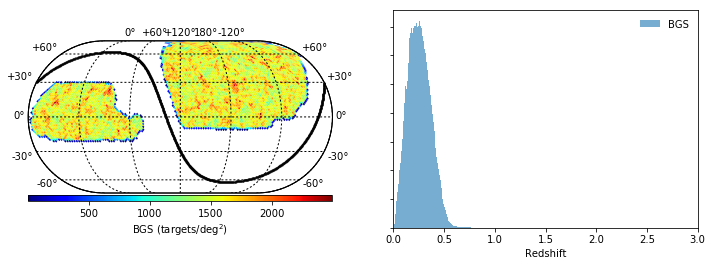

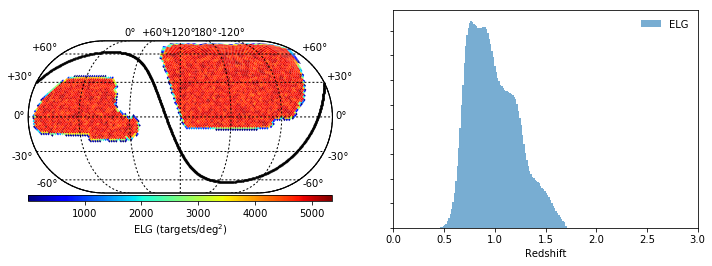

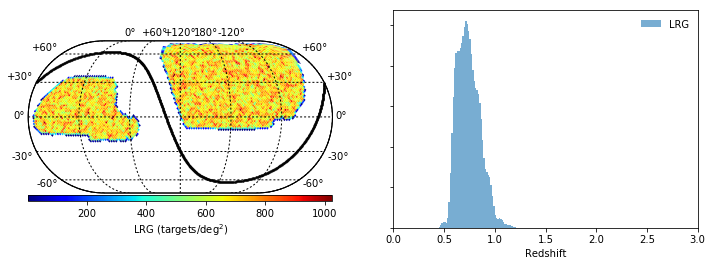

In [19]:
for obj in ('BGS', 'ELG', 'LRG'):
    qamock_sky(data[obj], obj)

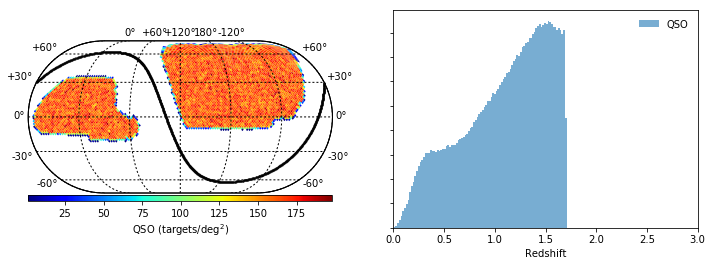

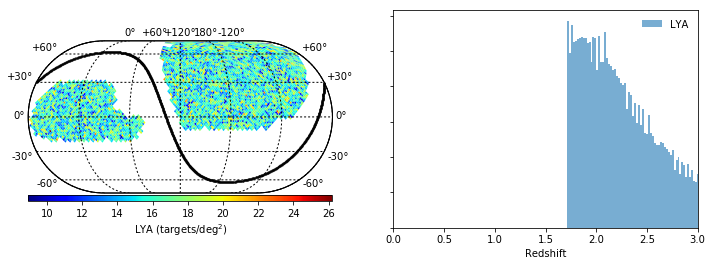

In [20]:
for obj in ('QSO', 'LYA'):
    qamock_sky(data[obj], obj)

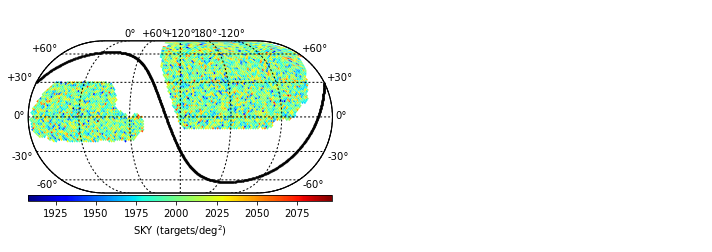

In [21]:
for obj in np.atleast_1d('SKY'):
    qamock_sky(data[obj], obj)

## 2. Generate and assess mock targets, spectra, and contaminants for each spectral type.

### 2a) Generate the target and truth catalogs.

In [22]:
def write_target_yaml(target='QSO', bounds=(203, 204, 0, 1), outfile='mock_input.yaml', verbose=False):
    """Write a yaml file on-the-fly for a *single* target type."""
    log.info('Writing {}'.format(outfile))
    yf = open(outfile, 'w')
    yf.write('dust_dir: {}\n'.format(os.path.join(os.getenv('DUST_DIR'), 'maps')))
    yf.write('decals_brick_info: {}\n'.format(os.path.join(os.getenv('DESI_ROOT'), 'target', 
                                                           'catalogs', 'brick-info-dr3.v0.0.1.fits')))
    yf.write('subset:\n')
    yf.write('    ra_dec_cut: True\n')
    for blabel, bbound in zip(('min_ra', 'max_ra', 'min_dec', 'max_dec'), bounds):
        yf.write('    {}: {:g}\n'.format(blabel, bbound))
    yf.write('sources:\n')
    for targ in np.atleast_1d(target):
        yf.write('    {}: {{\n'.format(targ.upper()))
        if targ == 'BGS':
            yf.write('        target_name: {},\n'.format(targ.upper()))
            yf.write('        mock_dir_name: {},\n'.format(_BGSpath()))
            yf.write('        magcut: 20.3\n')
            yf.write('        format: durham_mxxl_hdf5,\n')
        if targ == 'ELG':
            yf.write('        target_name: {},\n'.format(targ.upper()))
            yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
            yf.write('        format: gaussianfield,\n')
            yf.write('        density: 2400\n')
        if targ == 'LRG':
            yf.write('        target_name: {},\n'.format(targ.upper()))
            yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
            yf.write('        format: gaussianfield,\n')
        if targ == 'QSO':
            yf.write('        target_name: {},\n'.format(targ.upper()))
            yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
            yf.write('        format: gaussianfield,\n')
            yf.write('        density: 120\n')
        if targ == 'LYA':
            yf.write('        target_name: {},\n'.format('QSO'))
            yf.write('        mock_dir_name: {},\n'.format(_lyapath()))
            yf.write('        format: lya,\n')
            yf.write('        density: 50\n')
        if targ == 'MWS_MAIN':
            yf.write('        target_name: {},\n'.format('MWS_MAIN'))
            yf.write('        mock_dir_name: {},\n'.format(_mwspath(main=True)))
            yf.write('        format: galaxia,\n')
        if targ == 'SKY':
            yf.write('        target_name: {},\n'.format(targ.upper()))
            yf.write('        mock_dir_name: {},\n'.format(_GRFpath(sky=True)))
            yf.write('        format: gaussianfield,\n')
            yf.write('        density: 1400\n')
        yf.write('    }\n')
    yf.close()    
    if verbose:
        print()
        with(open(outfile, 'r')) as yf:
            print(yf.read())

In [23]:
def write_yaml(bounds=(203, 204, 0, 1), outfile='mock_input.yaml', verbose=False):
    """Write a yaml file on-the-fly for *all* target types."""
    log.info('Writing {}'.format(outfile))
    yf = open(outfile, 'w')
    yf.write('dust_dir: {}\n'.format(os.path.join(os.getenv('DUST_DIR'), 'maps')))
    yf.write('decals_brick_info: {}\n'.format(os.path.join(os.getenv('DESI_ROOT'), 'target', 
                                                           'catalogs', 'brick-info-dr3.v0.0.1.fits')))
    yf.write('subset:\n')
    yf.write('    ra_dec_cut: True\n')
    for blabel, bbound in zip(('min_ra', 'max_ra', 'min_dec', 'max_dec'), bounds):
        yf.write('    {}: {:g}\n'.format(blabel, bbound))
    yf.write('sources:\n')
    yf.write('    ELG: {\n')
    yf.write('        target_name: ELG,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 2400,\n')
    yf.write('        contam: {\n')
    yf.write('            MWS_MAIN: 240,\n')
    yf.write('        }\n')
    yf.write('    }\n')
    yf.write('    MWS_MAIN: {\n')
    yf.write('        target_name: MWS_MAIN,\n')
    yf.write('        mock_dir_name: {},\n'.format(_mwspath(main=True)))
    yf.write('        format: galaxia,\n')
    yf.write('    }\n')
    yf.write('    QSO: {\n')
    yf.write('        target_name: QSO,\n')
    yf.write('        mock_dir_name: {},\n'.format(_GRFpath()))
    yf.write('        format: gaussianfield,\n')
    yf.write('        density: 120,\n')
    yf.write('        contam: {\n')
    yf.write('            ELG: 27,\n')
    yf.write('            MWS_MAIN: 63,\n')
    yf.write('        }\n')
    yf.write('    }\n')
    yf.close()    
    if verbose:
        print()
        with(open(outfile, 'r')) as yf:
            print(yf.read())

In [27]:
def build_targets_truth(prefix='qatargets', seed=123, nproc=3, verbose=True, 
                        bounds=(203, 203.25, 0.125, 0.625), output_dir=None):
    """Simple wrapper on desitarget.mock.targets_truth.
    
    Prefix can also optionally be an object type (e.g., ELG).
    """
    from desitarget.mock.build import targets_truth
    
    if output_dir is None:
        output_dir = os.path.join(mockpath, '{}'.format(prefix))
    try:
        os.stat(output_dir)
    except:
        os.makedirs(output_dir)

    config_file = os.path.join(mockpath, '{}_input.yaml'.format(prefix))
    write_yaml(bounds=bounds, outfile=config_file, verbose=verbose)
    
    with open(config_file, 'r') as pfile:
        params = yaml.load(pfile)
    targets_truth(params, output_dir, realtargets=None, seed=seed, verbose=verbose, 
                  nproc=nproc, bricksize=0.25, outbricksize=0.25)

In [28]:
# Specify root path and the (ra,dec) boundaries.
prefix = 'qatargets'
mockpath = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', prefix)
radec_bounds = (203, 203.25, 0.125, 0.625)

In [29]:
# Build the mock catalogs.
build_targets_truth(seed=123, bounds=radec_bounds, prefix=prefix)

INFO:<ipython-input-23-523741b0dc99>:3:write_yaml: Writing /Users/ioannis/research/projects/desi/datachallenge/qatargets/qatargets_input.yaml

dust_dir: /Users/ioannis/research/data/sfd_dustmaps/maps
decals_brick_info: /Users/ioannis/research/projects/desi/target/catalogs/brick-info-dr3.v0.0.1.fits
subset:
    ra_dec_cut: True
    min_ra: 203
    max_ra: 203.25
    min_dec: 0.125
    max_dec: 0.625
sources:
    ELG: {
        target_name: ELG,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5,
        format: gaussianfield,
        density: 2400,
        contam: {
            MWS_MAIN: 240,
        }
    }
    MWS_MAIN: {
        target_name: MWS_MAIN,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/mws/galaxia/alpha/v0.0.3/bricks,
        format: galaxia,
    }
    QSO: {
        target_name: QSO,
        mock_dir_name: /Users/ioannis/research/projects/desi/mocks/GaussianRandomField/v0.0.5,
        format: gaussianfield,
 

/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_MAIN are set to one
  warnings.warn(mess, RuntimeWarning)
/Users/ioannis/repos/desihub/desitarget/py/desitarget/QA.py:72: RuntimeWarning: fluctuations for targettype MWS_MAIN are set to one
  warnings.warn(mess, RuntimeWarning)


INFO:build.py:496:targets_truth: Initializing the MockSpectra and SelectTargets classes.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/elg_templates_v2.0.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/star_templates_v2.1.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/qso_templates_v2.0.fits metadata.
INFO:io.py:613:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/wd_templ

In [ ]:
# Build mock catalogs for each object type individually (relegated).
if False:
    objtype = ('ELG')
    #objtype = ('ELG', 'QSO')
    for obj in np.atleast_1d(objtype):
        build_targets_truth(obj, seed=444, bounds=radec_bounds)

### 2b) Read the target and truth catalogs back in and do some sanity checks of the files.

In [30]:
def get_targtruth_files(prefix='qatargets'):
    output_dir = os.path.join(mockpath, '{}'.format(prefix))
    targfiles = glob(os.path.join(output_dir, '???', 'targets-*.fits'))#[:1]
    truthfiles = glob(os.path.join(output_dir, '???', 'truth-*.fits'))#[:1]
    return targfiles, truthfiles

In [31]:
def sanity_check_files(prefix='qatargets'):
    """Simple script to do some basic sanity checks of the files on disk."""
    targfiles, truthfiles = get_targtruth_files(prefix)
    log.info('Sanity checking {} target and {} truth files in directory {}.'.format(
        len(targfiles), len(truthfiles), prefix))
             
    if len(targfiles) != len(truthfiles):
        log.warning('Mismatch in the number of target (N={}) and truth (N={}) files!').format(
            len(targfiles), len(truthfiles))

    for targfile, truthfile in zip(np.atleast_1d(targfiles), np.atleast_1d(truthfiles)):
        targ = fitsio.FITS(targfile)
        truth = fitsio.FITS(truthfile)
        ntarg = targ[1].get_nrows()
        ntruth = truth[2].get_nrows()
        wave_dims = truth[0].get_dims()
        flux_dims = truth[1].get_dims()

        if (ntarg != ntruth):
            log.warning('{}: {} objects in TRUTH table, {} objects in TARGETS table.'.format(
                os.path.basename(targfile), ntruth, ntarg))

        if (flux_dims[0] != ntarg):
            log.warning('{}: {} objects in TRUTH table, {} spectra.'.format(
                os.path.basename(targfile), ntruth, flux_dims[0]))
            
        if (flux_dims[1] != wave_dims[0]):
            log.warning('{}}: {} pixels in wavelength vector, {} pixels in flux spectra.'.format(
                os.path.basename(targfile), wave_dims[0], flux_dims[1]))

In [32]:
def read_targets_truth(prefix):
    """Simple wrapper script to gather up all the target and truth catalogs."""
    targfiles, truthfiles = get_targtruth_files(prefix)
    targets, truth = [], []
    for targfile, truthfile in zip(np.atleast_1d(targfiles), np.atleast_1d(truthfiles)):
        targets.append(Table(fitsio.read(targfile, ext=1)))
        truth.append(Table(fitsio.read(truthfile, ext=2)))
    targets = vstack(targets)
    truth = vstack(truth)
    log.info('Read {} targets from {} bricks.'.format(len(targets), len(targfiles)))
    return targets, truth

In [33]:
sanity_check_files(prefix)

INFO:<ipython-input-31-39fe683ca49b>:5:sanity_check_files: Sanity checking 2 target and 2 truth files in directory qatargets.


### 2c) Make a variety of QAplots.

In [95]:
from matplotlib.patches import Polygon

In [120]:
def _grlim():
    return (-0.5, 2.0)

In [55]:
def _rzlim():
    return (-0.5, 2.2)

In [58]:
def _rW1lim():
    return (-2, 6)

In [106]:
def _grzrange():
    return (16, 24)

In [100]:
def _rmagrange():
    rmagrange = (16, 24)
    nrmagbins = 25
    return rmagrange, nrmagbins

In [86]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
        warnings.simplefilter('ignore')
        for ii, band in zip((1, 2, 4), ('g', 'r', 'z')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['DECAM_FLUX'][..., ii].data)
        for ii, band in zip((0, 1), ('W1', 'W2')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['WISE_FLUX'][..., ii].data)
        colors['grz'] = 22.5-2.5*np.log10((cat['DECAM_FLUX'][..., 1] + 
                                           0.8 * cat['DECAM_FLUX'][..., 2] +
                                           0.5 * cat['DECAM_FLUX'][..., 4]).data / 2.3)
        colors['W'] = 22.5-2.5*np.log10(0.75 * cat['WISE_FLUX'][..., 0] + 
                                        0.25 * cat['WISE_FLUX'][..., 1]) # for QSOs

    colors['gr'] = colors['g'] - colors['r']
    colors['rz'] = colors['r'] - colors['z']
    colors['rW1'] = colors['r'] - colors['W1']
    colors['W1W2'] = colors['W1'] - colors['W2']
    
    return colors

In [138]:
def elg_colorbox(ax):
    """Draw the ELG selection box."""
    rmaglim = 23.4
    grlim = ax.get_ylim()
    coeff0, coeff1 = (1.15, -0.15), (-1.2, 1.6)
    rzmin, rzpivot = 0.3, (coeff1[1] - coeff0[1]) / (coeff0[0] - coeff1[0])
    verts = [(rzmin, grlim[0]),
             (rzmin, np.polyval(coeff0, rzmin)),
             (rzpivot, np.polyval(coeff1, rzpivot)),
             ((grlim[0] - 0.1 - coeff1[1]) / coeff1[0], grlim[0] - 0.1)
            ]
    ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))
    return rmaglim

In [139]:
def qso_colorbox(ax, plottype='grz'):
    """Draw the QSO selection boxes."""
    rmaglim = 22.7
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if plottype == 'grz-r':
        verts = [(xlim[0]-0.05, 17.0),
                 (22.7, 17.0),
                 (22.7, ylim[1]+0.05),
                 (xlim[0]-0.05, ylim[1]+0.05)
                ]
    if plottype == 'rW1-rz':
        verts = None
        ax.axvline(x=-0.3, ls='--', color='k')
        ax.axvline(x=1.3, ls='--', color='k')

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', color='k'))

In [201]:
def qaplot_colorcolor(targets, objtype='ELG', truth=None, contam=False):
    """Make a few different color-color plots."""
    
    iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(objtype)) != 0)[0]
    if truth:
        cat = flux2colors(truth[iobj])
    else:
        cat = flux2colors(targets[iobj])

    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax[0].scatter(cat['rz'][these], cat['gr'][these], 
                              s=10, alpha=0.7, label=cc)
            ax[0].legend(loc='upper right')
    else:
        ax[0].scatter(cat['rz'], cat['gr'], s=10, alpha=0.7)
    ax[0].set_xlabel('$r - z$')
    ax[0].set_ylabel('$g - r$')
    ax[0].set_xlim(_rzlim())
    ax[0].set_ylim(_grlim())
    if objtype.upper() == 'ELG':
        elg_colorbox(ax[0])
    if objtype.upper() == 'QSO':
        qso_colorbox(ax[0], 'gr-rz')

    if objtype.upper() != 'QSO':
        if contam:
            for cc in np.atleast_1d(contam):
                these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
                if len(these) > 0:
                    ax[1].scatter(cat['rz'][these], cat['rW1'][these], 
                              s=10, alpha=0.7, label=cc)
        else:
            ax[1].scatter(cat['rz'], cat['rW1'], s=10, alpha=0.7)
    ax[1].set_xlabel('$r - z$')
    ax[1].set_ylabel('$r - W1$')
    ax[1].set_xlim(_rzlim())
    ax[1].set_ylim(_rW1lim())
    #if objtype.upper() == 'QSO':
    #    qso_colorbox(ax[1], 'rW1-rz')

    if contam:
        for cc in np.atleast_1d(contam):
            these = np.where(truth['TEMPLATETYPE'].data[iobj] == bytes(cc, 'utf-8'))[0]
            if len(these) > 0:
                ax[2].scatter(cat['r'][these], cat['grz'][these], 
                              s=10, alpha=0.7, label=cc)
    else:
        ax[2].scatter(cat['r'], cat['grz'], s=10, alpha=0.7)
    ax[2].set_xlabel('$r$')
    ax[2].set_ylabel('$grz$')
    ax[2].set_xlim(_rmagrange()[0])
    ax[2].set_ylim(_grzrange())
    if objtype.upper() == 'QSO':
        qso_colorbox(ax[2], 'grz-r')

    if truth:
        plt.suptitle('{} - All Targets, True Photometry'.format(objtype.upper()))
    else:
        plt.suptitle('{} - All Targets, Observed Photometry'.format(objtype.upper()))
        
    fig.subplots_adjust(wspace=0.25)

In [127]:
targets, truth = read_targets_truth(prefix)

INFO:<ipython-input-32-26f6e3b92bf9>:10:read_targets_truth: Read 556 targets from 2 bricks.


#### ELGs

In [181]:
objtype = 'ELG'

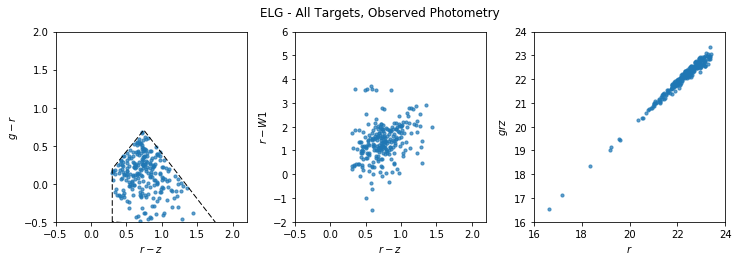

In [194]:
# All targets, observed (noisy) photometry.
qaplot_colorcolor(targets, objtype=objtype)

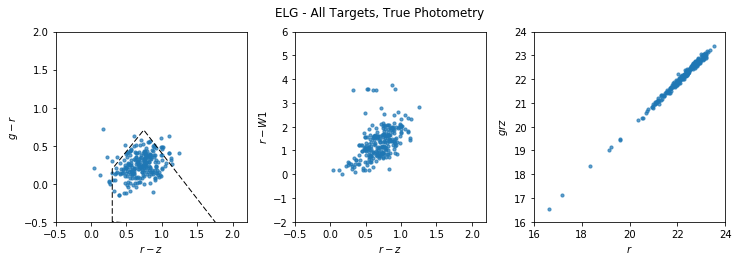

In [195]:
# All targets, true (noiseless) hpotometry.
qaplot_colorcolor(targets, objtype=objtype, truth=truth)

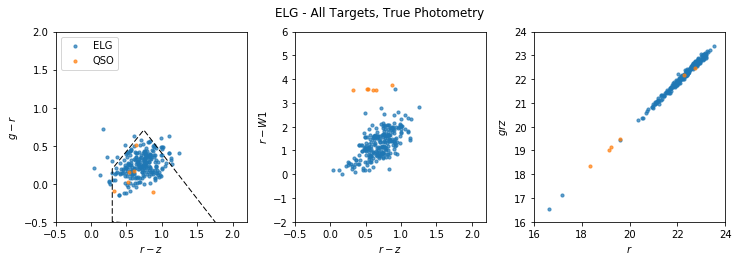

In [196]:
# Contaminants.
qaplot_colorcolor(targets, objtype=objtype, truth=truth, contam=['ELG', 'STAR', 'QSO'])

#### QSOs

In [197]:
objtype = 'QSO'

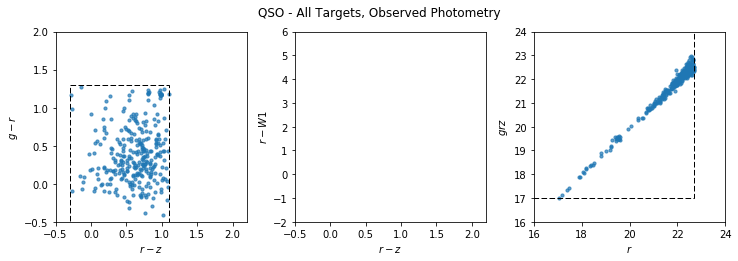

In [198]:
qaplot_colorcolor(targets, objtype=objtype)

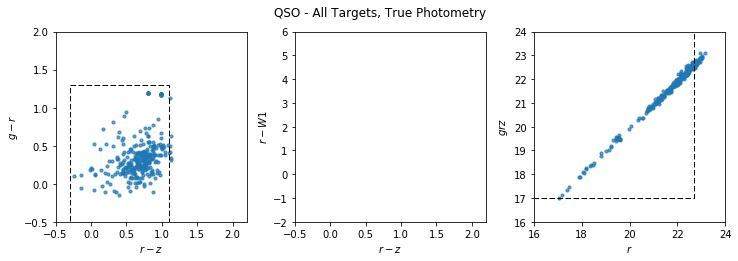

In [199]:
qaplot_colorcolor(targets, objtype=objtype, truth=truth)

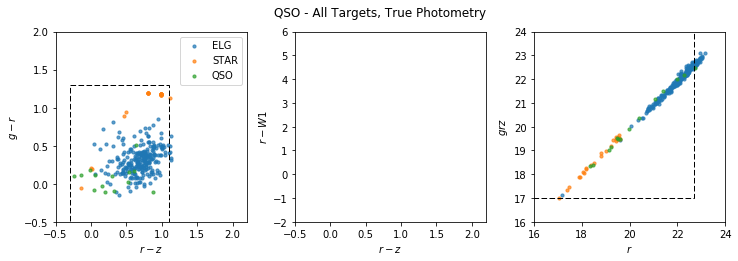

In [202]:
# Contaminants.
qaplot_colorcolor(targets, objtype=objtype, truth=truth, contam=['ELG', 'STAR', 'QSO'])

In [ ]:
def qaplot_noisy_vs_true(targcol, truecol, objtype='ELG'):
    grlim = (-0.3, 2.0)
    rzlim = (-0.5, 2.2)
    rmagrange = (18, 24)
    nrmagbins = 25
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
    # Color-color plots
    ax[0].scatter(targcol['rz'], targcol['gr'], color='orange', label='Noisy Colors')
    ax[1].scatter(truecol['rz'], truecol['gr'], color='dodgerblue', label='True Colors')    
    ax[0].set_ylabel('$g - r$')
    ax[1].yaxis.set_ticklabels([])
    ax[1].set_title('Noisy vs True Colors')
    for thisax in ax[:2]:
        thisax.set_xlabel('$r - z$')
        thisax.set_xlim(rzlim)
        thisax.set_ylim(grlim)
        thisax.legend(frameon=True)
        if objtype.upper() == 'ELG':
            rmaglim = elg_colorbox(thisax)
    # Magnitude histograms
    ax[2].hist(targcol['r'], bins=nrmagbins, range=rmagrange)
    ax[2].hist(trucol['r'], bins=nrmagbins, range=rmagrange, fill=False, 
               alpha=0.5, edgecolor='black')
    ax[2].yaxis.set_ticklabels([])
    ax[2].set_xlabel('$r$ (AB mag)')
    if objtype.upper() == 'ELG':
        ax[2].axvline(x=rmaglim, ls='--', color='red')
    fig.subplots_adjust(wspace=0.1)

In [150]:
iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(objtype)) != 0)[0]
truth[iobj]

TARGETID,MOCKID,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,DECAM_FLUX [6],WISE_FLUX [2],OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
int64,int64,float32,bytes13,bytes13,bytes13,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32
2337226566193840717,0,1.19522,GALAXY,ELG,,4434,1369091373,22.1662,1.1794 .. 2.65285,2.53973 .. 1.96228,1.04006e-16,-1.0,-1.0,-1.0,-1.0
3194962069485850431,2,1.09831,GALAXY,ELG,,2070,2971989760,22.3081,0.458256 .. 2.90552,7.33504 .. 5.97504,3.3577e-17,-1.0,-1.0,-1.0,-1.0
1275921460211889244,4,0.974217,GALAXY,ELG,,3217,2381057949,23.0298,0.312561 .. 1.51243,3.54082 .. 2.56221,5.93009e-17,-1.0,-1.0,-1.0,-1.0
3250211470755440972,6,0.942458,GALAXY,ELG,,4407,1670530003,21.9698,1.39785 .. 3.8052,3.65953 .. 2.50187,2.24717e-16,-1.0,-1.0,-1.0,-1.0
1229943115059641265,7,0.933487,GALAXY,ELG,,2683,1559520068,22.0196,1.67695 .. 3.07368,5.28786 .. 3.67127,7.19654e-17,-1.0,-1.0,-1.0,-1.0
1222780847799281119,9,0.921596,GALAXY,ELG,,187,3672080263,22.4087,0.56746 .. 2.33129,4.28668 .. 2.81601,2.70161e-16,-1.0,-1.0,-1.0,-1.0
13921054477271425,10,0.888369,GALAXY,ELG,,3116,3614945117,22.1036,1.16438 .. 2.0394,2.74665 .. 1.66732,1.95324e-16,-1.0,-1.0,-1.0,-1.0
1873692961969709789,12,0.877446,GALAXY,ELG,,5165,1535010876,22.0973,1.04229 .. 3.67938,5.50804 .. 3.92047,1.49772e-16,-1.0,-1.0,-1.0,-1.0
4607133042351009591,14,0.87944,GALAXY,ELG,,2253,187223924,22.385,1.02408 .. 1.78613,2.35617 .. 1.58944,1.63875e-16,-1.0,-1.0,-1.0,-1.0


In [37]:
def qaplot_grzW1W2_mags(targets, truth, objtype='ELG'):
    targcol = flux2colors(targets)
    truecol = flux2colors(truth)
    if objtype.upper() == 'QSO':
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True)
        ax1.hist(truecol['g'][np.isfinite(truecol['g'])])
        ax2.hist(truecol['r'][np.isfinite(truecol['r'])])
        ax3.hist(truecol['gr'][np.isfinite(truecol['gr'])])
        ax4.hist(truecol['rz'][np.isfinite(truecol['rz'])])
    #ax[0].set_ylabel('$g - r$')
    #for thisax in ax:
    #    thisax.set_xlabel('$r - z$')
    #fig.subplots_adjust(wspace=0.1)

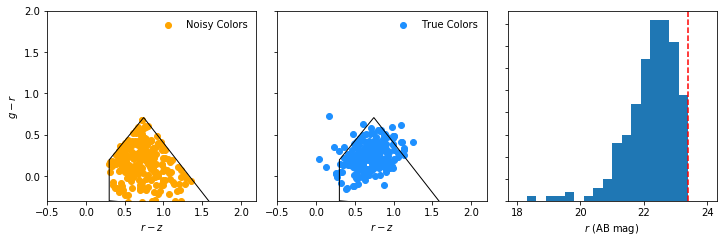

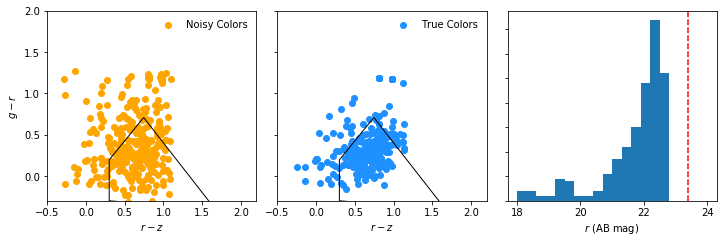

In [43]:
for obj in np.atleast_1d(('ELG', 'QSO')):
    iobj = np.where((targets['DESI_TARGET'] & desi_mask.mask(obj)) != 0)[0]
    targcol, trucol = flux2colors(targets[iobj]), flux2colors(truth[iobj])
    qaplot_colorcolor(targcol, trucol, objtype=obj)